In [66]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
import gseapy
from gseapy.plot import barplot, dotplot
import networkx as nx
from cdlib import algorithms
import OmicsIntegrator as oi
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats
import community 
import pickle
import itertools
from upsetplot import from_contents, UpSet
import get_binarized_map_of_selected_loci_3 as diff
from mne_connectivity.viz import plot_connectivity_circle
from tqdm import tqdm
import time
import random
import json

import get_binarized_map_of_selected_loci_4 as diff

In [446]:
# Reload modules in case of modifications
reload(diff)

<module 'get_binarized_map_of_selected_loci_4' from '/home/braunger/masterthesis/python_code/compare_hic/get_binarized_map_of_selected_loci_4.py'>

In [3]:
data_dir = '/home/braunger/masterthesis/data/'
save_dir = '/home/braunger/masterthesis/save/'
hic_dir = save_dir + 'processed_hic_data/'
fig_dir = '/home/braunger/masterthesis/save/figures/compare_hic/'

# 1. Binarized maps and difference matrix

In [4]:
young = pd.read_csv(hic_dir+'Young_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)
old = pd.read_csv(hic_dir+'Old_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)

# Differences between young and old
diff_map = young + 2 * old #0: no intermingling, 1: young-specific, 2: old-specific, 3: shared intermingling
print(diff_map.shape)
diff_map.to_csv(hic_dir+'difference_maps/diff_all_gene_loci.csv')

(5399, 5399)


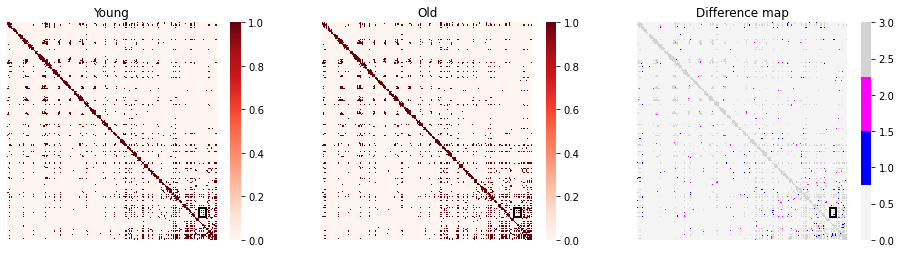

In [5]:
%matplotlib inline
diff.plot_binarized_maps(young, old, diff_map, filtering = False)
plt.savefig(fig_dir+'diff_map_all_loci', dpi = 500)

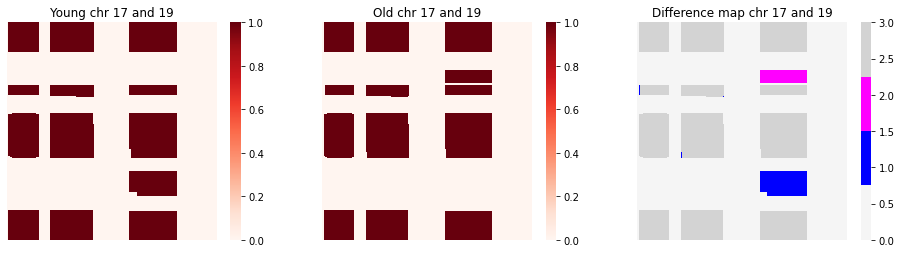

In [6]:
%matplotlib inline
diff.plot_binarized_maps_chr_pair(young, old, diff_map, chr_pair = (17, 19))
plt.savefig(fig_dir+'diff_map_chr17_19', dpi = 500)

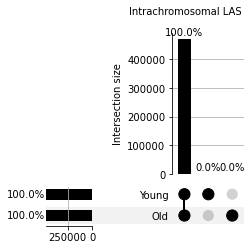

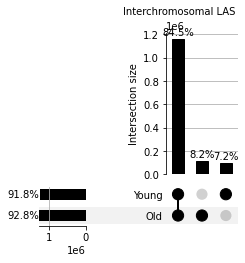

In [7]:
# How strongly do the interactions overlap
def get_intra(df):
    df['loc1'] = df.index
    df = pd.melt(df, id_vars = 'loc1', var_name = 'loc2')
    df = df[df['value'] != 0]
    df['chr1'] = df['loc1'].str.split('_').str[1]
    df['chr2'] = df['loc2'].str.split('_').str[1]
    df = df[df['chr1'] == df['chr2']]
    interactions = [df.iloc[ix, 0] + "-" + df.iloc[ix, 1] for ix in range(0, df.shape[0])]
    return interactions

def get_inter(df):
    df['loc1'] = df.index
    df = pd.melt(df, id_vars = 'loc1', var_name = 'loc2')
    df = df[df['value'] != 0]
    df['chr1'] = df['loc1'].str.split('_').str[1]
    df['chr2'] = df['loc2'].str.split('_').str[1]
    df = df[df['chr1'] != df['chr2']]
    interactions = [df.iloc[ix, 0] + "-" + df.iloc[ix, 1] for ix in range(0, df.shape[0])]
    return interactions

# UpSet plot for intrachromosomal contacts
intersections = from_contents({'Old': get_intra(old), 
                               'Young': get_intra(young)})
upset = UpSet(intersections, subset_size='count', show_percentages = True,
             sort_by="cardinality", sort_categories_by=None).plot()
plt.figtext(0.45, 0.95, 'Intrachromosomal LAS')
plt.savefig(fig_dir + 'intra_LAS_intersections.png', dpi = 500, bbox_inches="tight")
plt.show()

# UpSet plot for interchromosomal contacts
intersections = from_contents({'Old': get_inter(old),
                               'Young': get_inter(young)})
upset = UpSet(intersections, subset_size='count', show_percentages = True,  
              sort_by="cardinality", sort_categories_by=None).plot()
plt.figtext(0.45, 0.95, 'Interchromosomal LAS')
plt.savefig(fig_dir + 'inter_LAS_intersections.png', dpi = 500, bbox_inches="tight")
plt.show()

# 2. Number of intermingling regions per chromosome pair

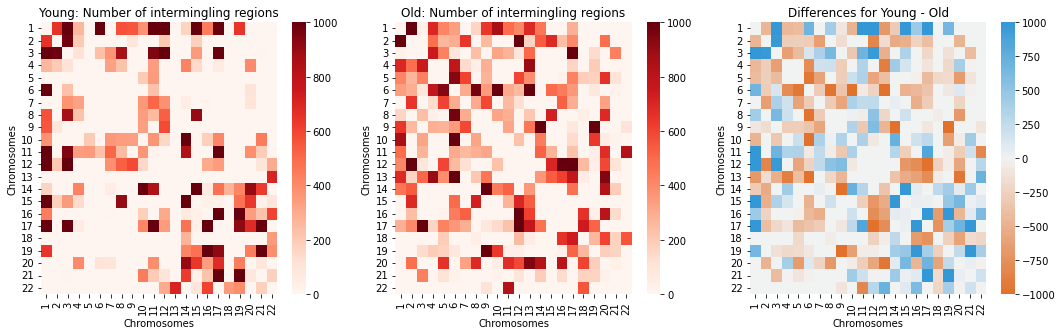

In [8]:
chr_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
fig, axs = plt.subplots(1, 3, figsize = (18, 5))
diff.plot_specific_intermingling(chr_list, diff_map, "Young", axs[0])
diff.plot_specific_intermingling(chr_list, diff_map, "Old", axs[1])
diff.plot_intermingling_diff(chr_list, diff_map, "Young", "Old", axs[2], -1000, 1000)
plt.savefig(fig_dir + 'specific_intermingling_per_chr_pair.png', dpi = 500, bbox_inches="tight")
plt.show()

# 3. Difference maps
## a) For all upregulated genes in Group1

(170, 7)
(158, 158)


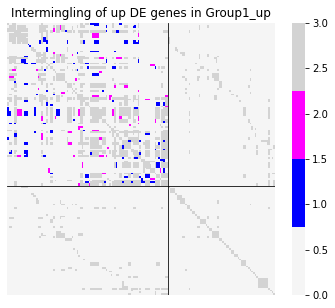

In [403]:
# Upregulated genes in group 1 
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'Group1_up', 'up', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_up_Group1.png', dpi = 500, bbox_inches="tight")

In [432]:
DE_diff_map = diff.get_diff_map_DE(diff_map, 'Group1_up', 'up', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)
sum_im = young_specific_im + old_specific_im + shared_im

# randomly sampling same number per chromosome
#diff.quantify_im_changes(diff_map, 'Group1_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
#plt.savefig(fig_dir + 'hist_im_types_Group1_up.png', dpi = 500, bbox_inches="tight")

(170, 7)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [54:54<00:00,  3.29s/it]


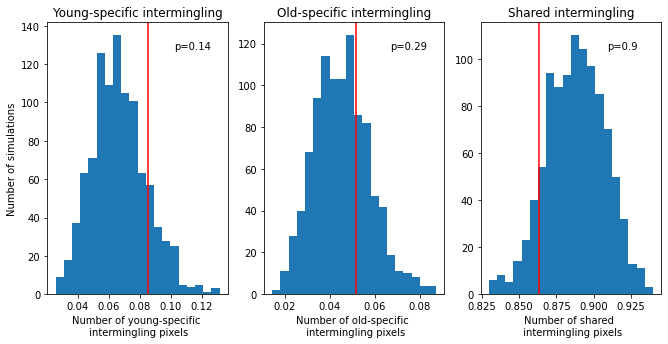

In [405]:
# randomly sampling genes from all chromosomes
diff.quantify_im_changes(diff_map, 'Group1_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'random_im_all_chr_Group1_up_percent.png', dpi = 500, bbox_inches="tight")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [55:18<00:00,  3.32s/it]


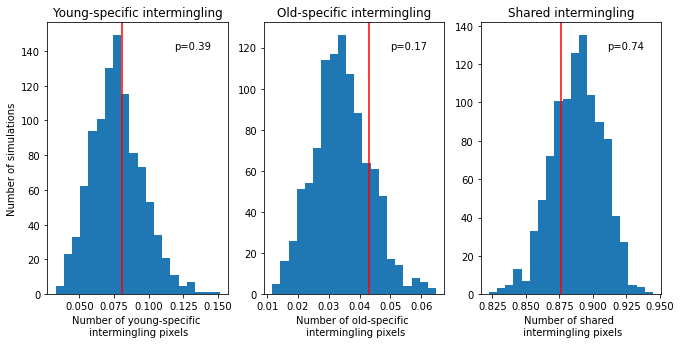

In [350]:
# percent randomly sampling genes from same chromosomes
diff.quantify_im_changes_chr(diff_map, 'Group1_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'random_im_same_chr_Group1_up_percent.png', dpi = 500, bbox_inches="tight")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [55:04<00:00,  3.30s/it]


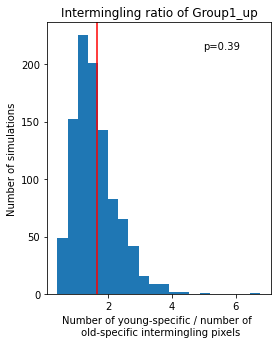

In [453]:
# young / old-specific intermingling ratio
diff.quantify_im_ratio(diff_map, 'Group1_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'im_ratio_Group1_up.png', dpi = 500, bbox_inches="tight")

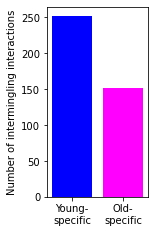

In [406]:
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im, old_specific_im], color = ['blue', 'magenta'])
plt.ylabel('Number of intermingling interactions')
plt.savefig(fig_dir + 'bars_Group1_up.png', dpi = 500, bbox_inches="tight")
plt.show()

Young-specific:  8.530805687203792 Old-specific:  5.145565335138795


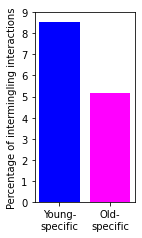

In [424]:
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im / sum_im * 100, old_specific_im / sum_im * 100], color = ['blue', 'magenta'])
plt.ylabel('Percentage of intermingling interactions')
plt.ylim(0, 9)
plt.savefig(fig_dir + 'bars_percent_Group1_up.png', dpi = 500, bbox_inches="tight")
plt.show()
print('Young-specific: ', young_specific_im / sum_im * 100, 'Old-specific: ', old_specific_im / sum_im * 100)

## b) For all downregulated genes in Group 1

(170, 7)
(153, 153)


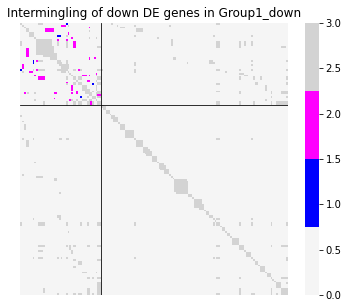

In [408]:
# Downregulated genes in group 1 
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'Group1_down', 'down', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_down_Group1.png', dpi = 500, bbox_inches="tight")

In [461]:
DE_diff_map = diff.get_diff_map_DE(diff_map, 'Group1_down', 'down', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)
sum_im = young_specific_im + old_specific_im + shared_im

#diff.quantify_im_changes(diff_map, 'Group1_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
#plt.savefig(fig_dir + 'hist_im_types_Group1_down.png', dpi = 500, bbox_inches="tight")

(170, 7)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [53:22<00:00,  3.20s/it]


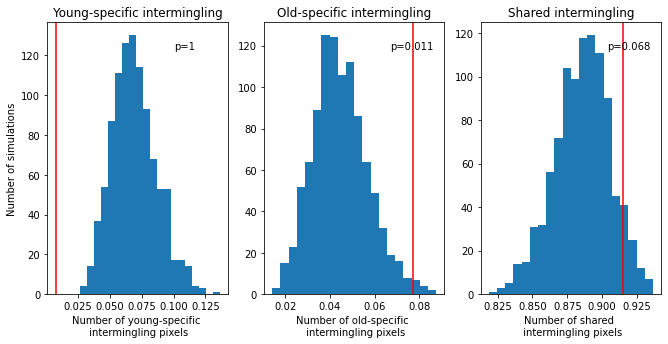

In [410]:
# randomly sampling genes from all chromosomes
diff.quantify_im_changes(diff_map, 'Group1_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'random_im_all_chr_Group1_down_percent.png', dpi = 500, bbox_inches="tight")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [53:49<00:00,  3.23s/it]


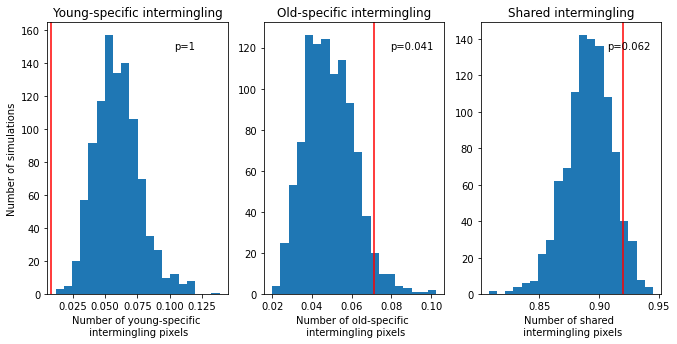

In [359]:
# percent randomly sampling genes from same chromosomes
diff.quantify_im_changes_chr(diff_map, 'Group1_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'random_im_same_chr_Group1_down_percent.png', dpi = 500, bbox_inches="tight")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:33:10<00:00,  5.59s/it]


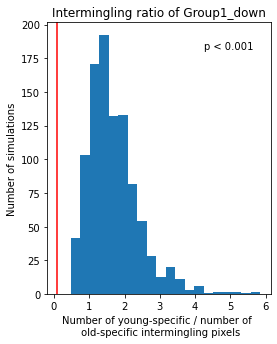

In [462]:
# young / old-specific intermingling ratio
diff.quantify_im_ratio(diff_map, 'Group1_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'im_ratio_Group1_down.png', dpi = 500, bbox_inches="tight")

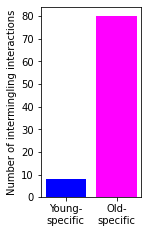

In [411]:
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im, old_specific_im], color = ['blue', 'magenta'])
plt.ylabel('Number of intermingling interactions')
plt.savefig(fig_dir + 'bars_Group1_down.png', dpi = 500, bbox_inches="tight")
plt.show()

Young-specific:  0.7714561234329798 Old-specific:  7.714561234329798


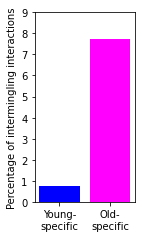

In [426]:
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im / sum_im * 100, old_specific_im / sum_im * 100], color = ['blue', 'magenta'])
plt.ylabel('Percentage of intermingling interactions')
plt.ylim(0, 9)
plt.savefig(fig_dir + 'bars_percent_Group1_down.png', dpi = 500, bbox_inches="tight")
plt.show()
print('Young-specific: ', young_specific_im / sum_im * 100, 'Old-specific: ', old_specific_im / sum_im * 100)

## c) For all upregulated genes in Group 4 & 5

(200, 5)
(187, 187)


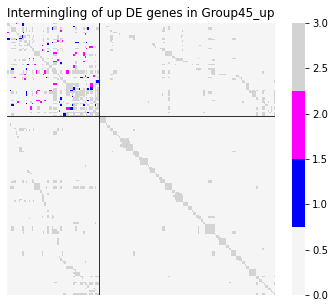

In [235]:
# Upregulated genes in group 4&5 
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'Group45_up', 'up', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_up_Group45.png', dpi = 500, bbox_inches="tight")

(200, 5)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:15:34<00:00,  4.53s/it]


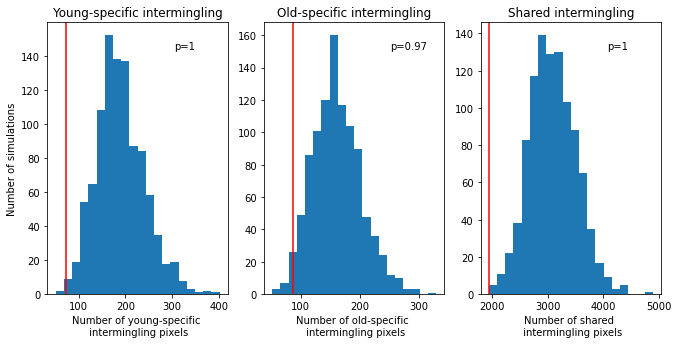

In [248]:
DE_diff_map = diff.get_diff_map_DE(diff_map, 'Group45_up', 'up', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)

diff.quantify_im_changes(diff_map, 'Group45_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'hist_im_types_Group45_up.png', dpi = 500, bbox_inches="tight")

## d) For all downregulated genes in Group 4 & 5

(200, 5)
(190, 190)


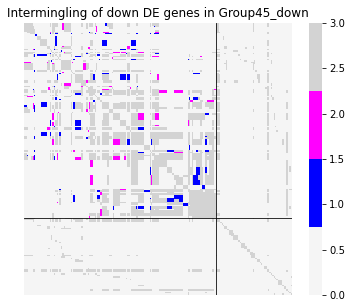

In [236]:
# Downregulated genes in group 4&5 
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'Group45_down', 'down', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_down_Group45.png', dpi = 500, bbox_inches="tight")

(200, 5)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:19:01<00:00,  4.74s/it]


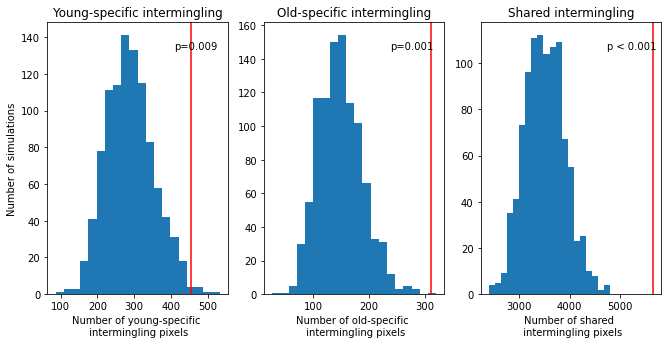

In [249]:
DE_diff_map = diff.get_diff_map_DE(diff_map, 'Group45_down', 'down', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)

diff.quantify_im_changes(diff_map, 'Group45_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'hist_im_types_Group45_down.png', dpi = 500, bbox_inches="tight")

## e) For all upregulated genes in Group 5

(170, 7)
(154, 154)


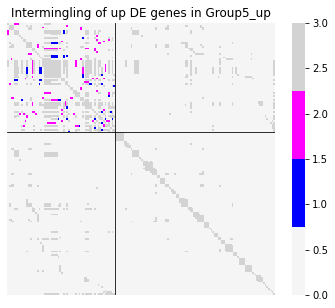

In [413]:
# Upregulated genes in group 5 
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'Group5_up', 'up', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_up_Group5.png', dpi = 500, bbox_inches="tight")

In [455]:
DE_diff_map = diff.get_diff_map_DE(diff_map, 'Group5_up', 'up', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)
sum_im = young_specific_im + old_specific_im + shared_im

#diff.quantify_im_changes(diff_map, 'Group5_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
#plt.savefig(fig_dir + 'hist_im_types_Group5_up.png', dpi = 500, bbox_inches="tight")

(170, 7)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [53:29<00:00,  3.21s/it]


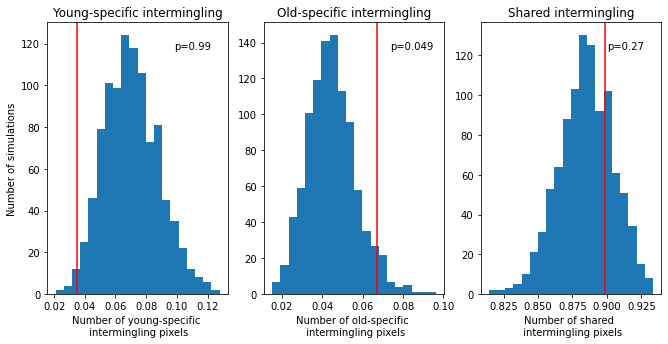

In [415]:
# randomly sampling genes from all chromosomes
diff.quantify_im_changes(diff_map, 'Group5_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'random_im_all_chr_Group5_up_percent.png', dpi = 500, bbox_inches="tight")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [54:36<00:00,  3.28s/it]


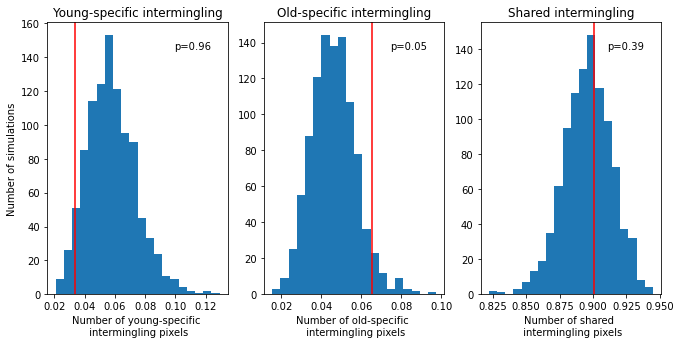

In [362]:
# percent randomly sampling genes from same chromosomes
diff.quantify_im_changes_chr(diff_map, 'Group5_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'random_im_same_chr_Group5_up_percent.png', dpi = 500, bbox_inches="tight")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [53:33<00:00,  3.21s/it]


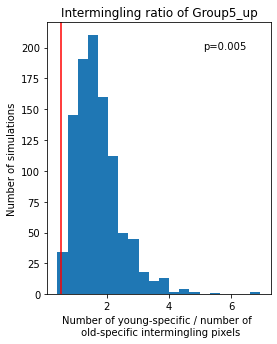

In [456]:
# young / old-specific intermingling ratio
diff.quantify_im_ratio(diff_map, 'Group5_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'im_ratio_Group5_up.png', dpi = 500, bbox_inches="tight")

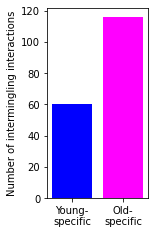

In [416]:
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im, old_specific_im], color = ['blue', 'magenta'])
plt.ylabel('Number of intermingling interactions')
plt.savefig(fig_dir + 'bars_Group5_up.png', dpi = 500, bbox_inches="tight")
plt.show()

Young-specific:  3.4682080924855487 Old-specific:  6.705202312138728


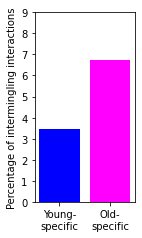

In [428]:
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im / sum_im * 100, old_specific_im / sum_im * 100], color = ['blue', 'magenta'])
plt.ylabel('Percentage of intermingling interactions')
plt.ylim(0, 9)
plt.savefig(fig_dir + 'bars_percent_Group5_up.png', dpi = 500, bbox_inches="tight")
plt.show()
print('Young-specific: ', young_specific_im / sum_im * 100, 'Old-specific: ', old_specific_im / sum_im * 100)

## f) For all downregulated genes in Group 5

(170, 7)
(163, 163)


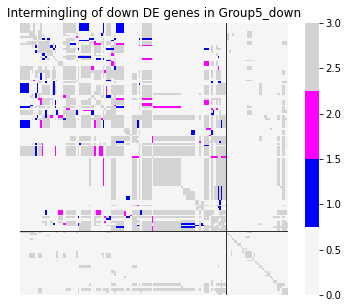

In [418]:
# Downregulated genes in group 5 
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'Group5_down', 'down', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_down_Group5.png', dpi = 500, bbox_inches="tight")

In [459]:
DE_diff_map = diff.get_diff_map_DE(diff_map, 'Group5_down', 'down', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)
sum_im = young_specific_im + old_specific_im + shared_im

#diff.quantify_im_changes(diff_map, 'Group5_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
#plt.savefig(fig_dir + 'hist_im_types_Group5_down.png', dpi = 500, bbox_inches="tight")

(170, 7)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [56:30<00:00,  3.39s/it]


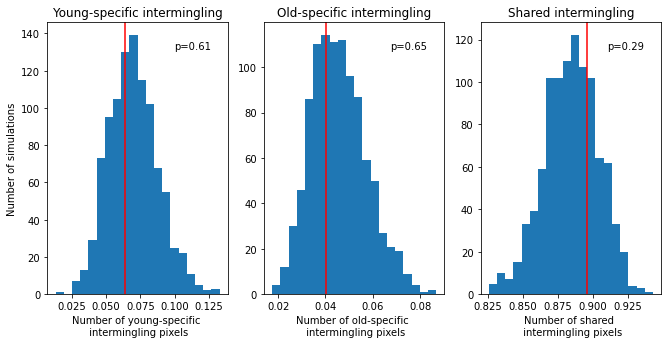

In [420]:
# randomly sampling genes from all chromosomes
diff.quantify_im_changes(diff_map, 'Group5_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'random_im_all_chr_Group5_down_percent.png', dpi = 500, bbox_inches="tight")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [55:56<00:00,  3.36s/it]


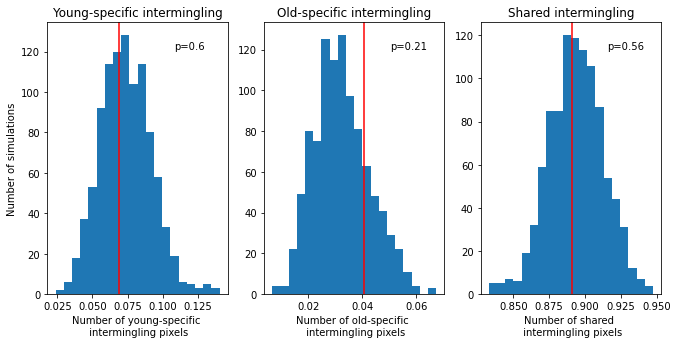

In [365]:
# percent randomly sampling genes from same chromosomes
diff.quantify_im_changes_chr(diff_map, 'Group5_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'random_im_same_chr_Group5_down_percent.png', dpi = 500, bbox_inches="tight")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:40:55<00:00,  6.06s/it]


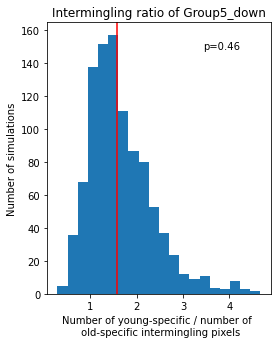

In [460]:
# young / old-specific intermingling ratio
diff.quantify_im_ratio(diff_map, 'Group5_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'im_ratio_Group5_down.png', dpi = 500, bbox_inches="tight")

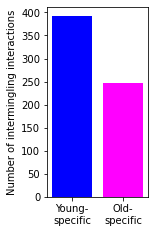

In [421]:
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im, old_specific_im], color = ['blue', 'magenta'])
plt.ylabel('Number of intermingling interactions')
plt.savefig(fig_dir + 'bars_Group5_down.png', dpi = 500, bbox_inches="tight")
plt.show()

Young-specific:  6.381246947745402 Old-specific:  4.03711541592056


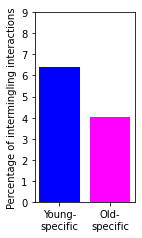

In [430]:
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im / sum_im * 100, old_specific_im / sum_im * 100], color = ['blue', 'magenta'])
plt.ylabel('Percentage of intermingling interactions')
plt.ylim(0, 9)
plt.savefig(fig_dir + 'bars_percent_Group5_down.png', dpi = 500, bbox_inches="tight")
plt.show()
print('Young-specific: ', young_specific_im / sum_im * 100, 'Old-specific: ', old_specific_im / sum_im * 100)

## g) For all upregulated genes in Group 4

(171, 5)
(163, 163)


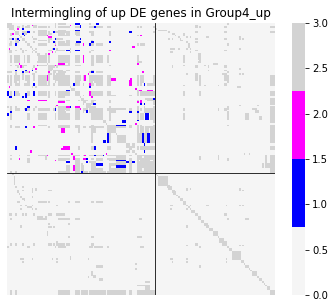

In [243]:
# Upregulated genes in group 4 
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'Group4_up', 'up', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_up_Group4.png', dpi = 500, bbox_inches="tight")

(171, 5)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:04:35<00:00,  3.88s/it]


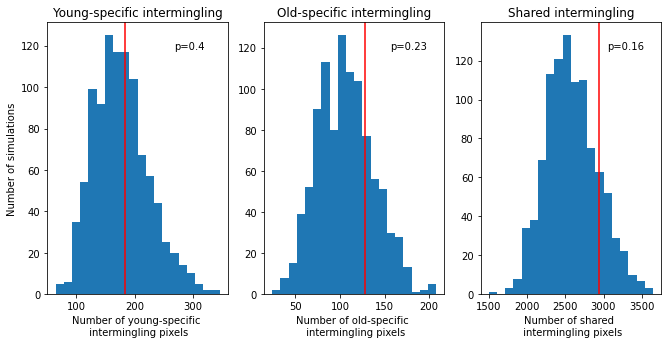

In [252]:
DE_diff_map = diff.get_diff_map_DE(diff_map, 'Group4_up', 'up', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)

diff.quantify_im_changes(diff_map, 'Group4_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'hist_im_types_Group4_up.png', dpi = 500, bbox_inches="tight")

## h) For all downregulated genes in Group 4

(170, 5)
(157, 157)


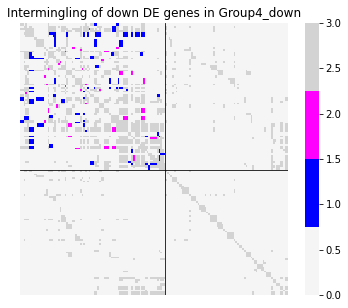

In [244]:
# Downregulated genes in group 4 
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'Group4_down', 'down', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_down_Group4.png', dpi = 500, bbox_inches="tight")

(170, 5)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:01:55<00:00,  3.72s/it]


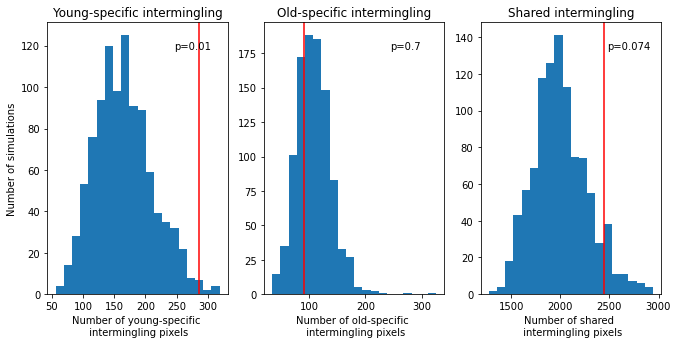

In [253]:
DE_diff_map = diff.get_diff_map_DE(diff_map, 'Group4_down', 'down', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)

diff.quantify_im_changes(diff_map, 'Group4_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'hist_im_types_Group4_down.png', dpi = 500, bbox_inches="tight")

## i) Continuous DE genes

(351, 5)
(322, 322)


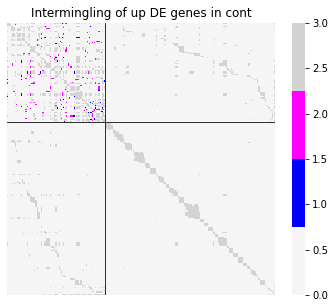

In [217]:
# Upregulated genes 
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'cont', 'up', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_up_cont.png', dpi = 500, bbox_inches="tight")

(351, 5)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:02:23<00:00,  3.74s/it]


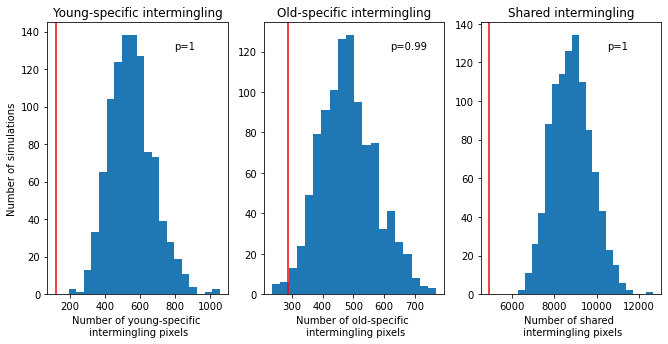

In [218]:
DE_diff_map = diff.get_diff_map_DE(diff_map, 'cont', 'up', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)

diff.quantify_im_changes(diff_map, 'cont', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'hist_im_types_cont_up.png', dpi = 500, bbox_inches="tight")

(59, 5)
(56, 56)


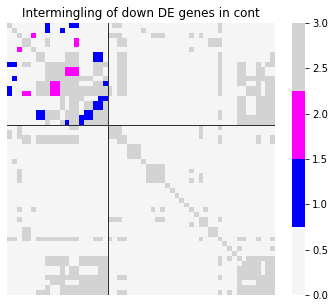

In [219]:
# Downregulated genes 
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'cont', 'down', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_down_cont.png', dpi = 500, bbox_inches="tight")

(59, 5)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [49:01<00:00,  2.94s/it]


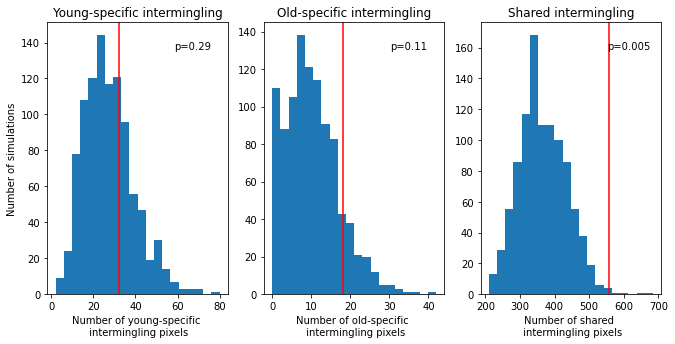

In [220]:
DE_diff_map = diff.get_diff_map_DE(diff_map, 'cont', 'down', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)

diff.quantify_im_changes(diff_map, 'cont', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'hist_im_types_cont_down.png', dpi = 500, bbox_inches="tight")

## 4. Number of bridge TFs targeting DE genes

(170, 5)


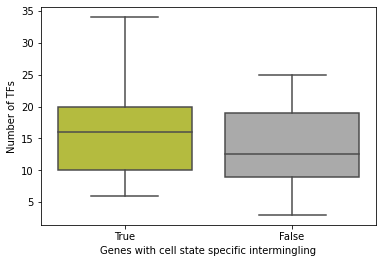

In [254]:
DE_diff_map = diff.get_diff_map_DE(diff_map, 'Group5', 'down', data_dir, save_dir)
intermingling_genes = DE_diff_map.columns[(DE_diff_map.isin([1, 2])).any(axis=1)].tolist()
TFs =  pd.read_csv(save_dir + 'pcst/TFs_centrality_group5.csv')['TF']

TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
DE_genes = pd.read_csv(data_dir+'de_data/DE_Group5.csv')
DE_genes = DE_genes[DE_genes['updown'] == 'down']
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
TF_targets = TF_targets[TF_targets['TF'].isin(TFs)]

target_counts = TF_targets.groupby('target')['target'].count()
target_counts = pd.DataFrame({'target': target_counts.index, 
                              'n_TFs': target_counts.values, 
                              'intermingling': 'False'})
target_counts.loc[target_counts['target'].isin(intermingling_genes), 'intermingling'] = 'True'
target_counts.to_csv(save_dir+'DE_genes/n_TFs_per_group5_DE_gene.csv', index = False)

plt.figure()
my_pal = {"False": "#aaaaaa", "True": "#c6d02a"}
sns.boxplot(data=target_counts, x='intermingling', y='n_TFs', palette = my_pal) 
plt.ylabel('Number of TFs')
plt.xlabel('Genes with cell state specific intermingling')
plt.savefig(fig_dir + 'n_TFs_group5_DE.png')
plt.show()

In [255]:
stats.ttest_ind(target_counts.loc[target_counts['intermingling'] == 'True', 'n_TFs'],
                target_counts.loc[target_counts['intermingling'] == 'False', 'n_TFs'], 
                alternative = 'greater')

Ttest_indResult(statistic=2.0256314649967493, pvalue=0.02252924023841022)

## 5. Intermingling between DE targets of each TF

In [256]:
# Quantify amount of intermingling between the DE targets of each TF
spec_intermingling = pd.DataFrame({'TF': [], 'spec_intermingling': [], 'shared_intermingling': []})
for TF in TFs:
    
    # load DE targets of selected TF
    TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
    TF_targets = TF_targets[TF_targets['TF'] == TF]
    TF_targets = TF_targets[TF_targets['target'].isin(DE_diff_map.columns)]
    
    # calculate percentages of cell-state specific and shared intermingling
    TF_diff_long = DE_diff_map.loc[TF_targets['target'], TF_targets['target']]
    TF_diff_long['loc1'] = TF_diff_long.index
    TF_diff_long = TF_diff_long.melt(id_vars = 'loc1', var_name = 'loc2')
    count_spec_im = TF_diff_long['value'].isin([1,2]).sum() / TF_diff_long.shape[0]
    count_shared_im = TF_diff_long['value'].isin([3]).sum() / TF_diff_long.shape[0]
    spec_intermingling = pd.concat([spec_intermingling, 
                                   pd.DataFrame({'TF': [TF], 
                                                'spec_intermingling': count_spec_im, 
                                                'shared_intermingling': count_shared_im})], 
                                   ignore_index = True)
     
spec_intermingling.to_csv(hic_dir + 'spec_intermingling_group5.csv', index = False)    
print(spec_intermingling.head())

       TF  spec_intermingling  shared_intermingling
0  STAT5A                 0.0              1.000000
1    MAFF                 0.0              0.265306
2    MAFK                 0.0              0.666667
3   HIF1A                 0.0              0.500000
4   FOXO3                 0.0              0.500000


## 6. Intermingling for DE targets of one TF

(29, 2)


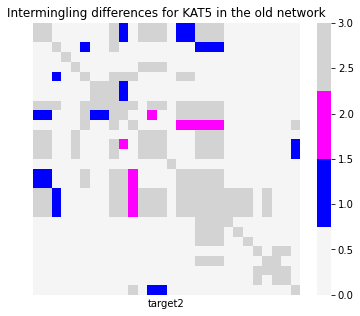

In [257]:
diff.diff_map_TF_transition(diff_map, 'KAT5', 'fc_61-85_86-96', 'old', data_dir, save_dir)

(29, 1)


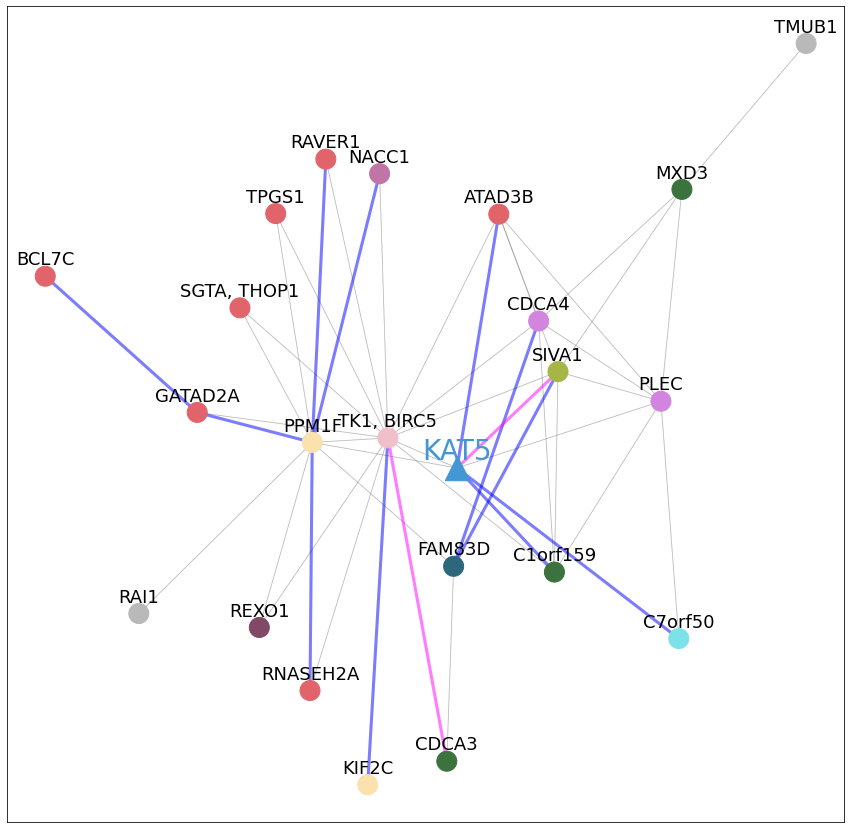

In [275]:
# Create network for downregulated Group 5 DE genes of one TF
TF = 'KAT5'

# load downregulated DE genes
DE_genes = pd.read_csv(data_dir+'de_data/DE_Group5.csv')
DE_genes = DE_genes[DE_genes['updown'] == 'down']
DE_genes = DE_genes[['gene']]
# load targets of selected TF
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['TF'] == TF]
DE_genes = DE_genes[DE_genes['gene'].isin(TF_targets['target'])]
print(DE_genes.shape)
# add TF
DE_genes = pd.concat([DE_genes, pd.DataFrame({'gene': [TF]})])
    
# load loci of all DE targets
all_gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
DE_genes = DE_genes.merge(all_gene_loci, on = "gene")

# merge genes from the same locus
DE_genes['gene'] = DE_genes.groupby(['locus'])['gene'].transform(lambda x: ', '.join(x))
DE_genes = DE_genes.drop_duplicates()
DE_genes['chromosome'] = [locus.split("_")[1] for locus in DE_genes['locus']]

# define colors based on the chromosome
chr_palette = pd.DataFrame({'chromosome': [str(i) for i in range(1, 23)],
                           'color': ["#3C723E", "#743F27", "#CD3836", "#F7D24A", "#A7B547", "#76CE97", 
                                     "#B9B9B9", "#F0BFC9", "#434679", "#8CCBEF", "#4397D4", 
                                     "#2C677C", "#7E8180", "#D285DE", "#6F1C16", "#814965", "#FAE1AE", 
                                     "#4299A9", "#E1646B", "#7DE2E7", "#B10DA1", "#C075A6"] })
DE_genes = DE_genes.merge(chr_palette, on = 'chromosome')

# create diff_map 
diff_map_long = diff_map.copy()
diff_map_long['loc1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'loc1', var_name = 'loc2')
diff_map_long = diff_map_long[diff_map_long['loc1'].isin(DE_genes['locus']) & diff_map_long['loc2'].isin(DE_genes['locus'])]
diff_map_long = DE_genes.rename(columns={"gene": "gene1", "locus": "loc1", "chromosome": "chr1"}).merge(diff_map_long, on = 'loc1')
diff_map_long = DE_genes.rename(columns={"gene": "gene2", "locus": "loc2", "chromosome": "chr2"}).merge(diff_map_long, on = 'loc2')
# remove intrachromosomal edges
diff_map_long = diff_map_long[diff_map_long['chr1'] != diff_map_long['chr2']]
diff_map_long = diff_map_long[['gene1', 'gene2', 'value']]
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long = diff_map_long.replace([1, 2, 3], ['young', 'old', 'shared'])

# create network
network = nx.from_pandas_edgelist(diff_map_long, 'gene1', 'gene2', 'value')

# draw network
plt.figure(figsize = (15,15))
pos = nx.layout.kamada_kawai_layout(network,
                                    weight=None,
                                    scale=10)
pos['KAT5'] = np.array([1, -0.7])

# Draw terminals 
DE_genes = DE_genes.set_index('gene')
DE_genes = DE_genes.reindex(network.nodes())
targets = [protein for protein in diff_map_long['gene1'].unique() if protein != TF]
 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = targets,
                       node_color= DE_genes.loc[DE_genes.index != TF, 'color'],
                       node_size=400,
                       node_shape='o',
                       alpha=1)
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = [TF],
                       node_color = DE_genes.loc[DE_genes.index == TF, 'color'],
                       node_size=600,
                       node_shape='^',
                       alpha=1)

# Draw edges
# shared interchromosomal intermingling
shared_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'shared'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = shared_edges,
                       width=0.8, 
                       alpha=0.3, 
                       edge_color='grey')

# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'young'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'old'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='magenta')

# Draw labels
labels = {protein: protein for protein in diff_map_long['gene1'].unique() if protein not in [TF]}
new_pos = {protein: np.array([x, y + 0.25]) 
           for protein, (x,y) in pos.items()}
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = labels,
                        font_size=18)
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = {TF: TF},
                        font_color = DE_genes.loc[DE_genes.index == TF, 'color'].item(),
                        font_size=28)

plt.savefig(fig_dir + 'network_KAT5.png', dpi = 500, bbox_inches="tight")
plt.show()

(30, 1)


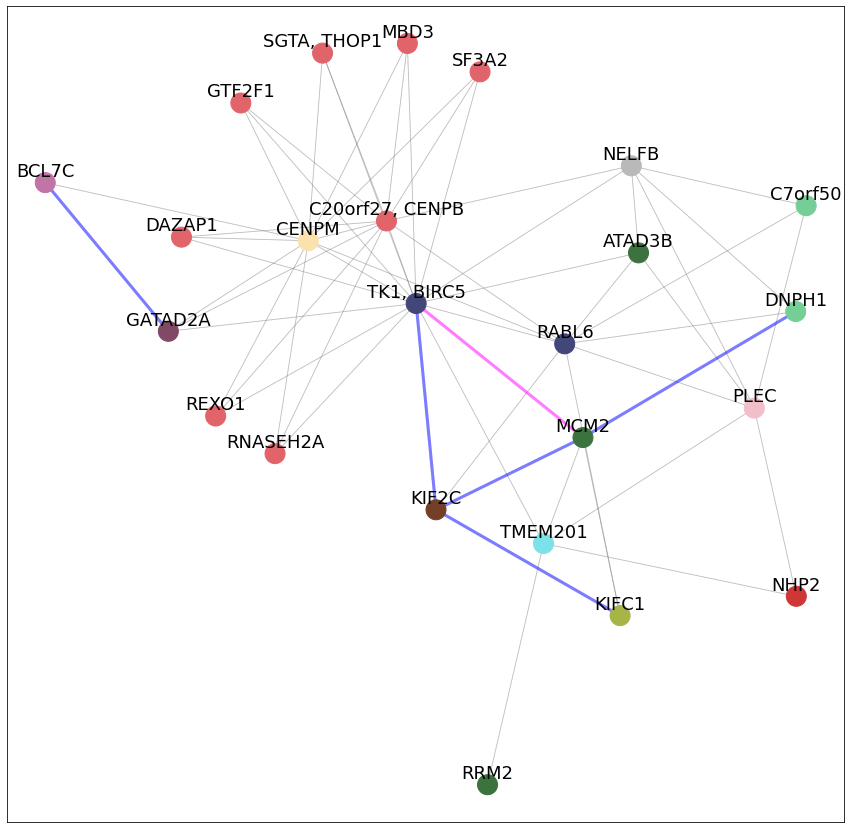

In [283]:
TF = 'MYC'

# load downregulated DE genes
DE_genes = pd.read_csv(data_dir+'de_data/DE_Group5.csv')
DE_genes = DE_genes[DE_genes['updown'] == 'down']
DE_genes = DE_genes[['gene']]
# load targets of selected TF
TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
TF_targets = TF_targets[TF_targets['TF'] == TF]
DE_genes = DE_genes[DE_genes['gene'].isin(TF_targets['target'])]
print(DE_genes.shape)
# add TF
DE_genes = pd.concat([DE_genes, pd.DataFrame({'gene': [TF]})])
    
# load loci of all DE targets
all_gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
DE_genes = DE_genes.merge(all_gene_loci, on = "gene")

# merge genes from the same locus
DE_genes['gene'] = DE_genes.groupby(['locus'])['gene'].transform(lambda x: ', '.join(x))
DE_genes = DE_genes.drop_duplicates()
DE_genes['chromosome'] = [locus.split("_")[1] for locus in DE_genes['locus']]

# define colors based on the chromosome
chr_palette = pd.DataFrame({'chromosome': [str(i) for i in range(1, 23)],
                           'color': ["#3C723E", "#743F27", "#CD3836", "#F7D24A", "#A7B547", "#76CE97", 
                                     "#B9B9B9", "#F0BFC9", "#434679", "#8CCBEF", "#4397D4", 
                                     "#2C677C", "#7E8180", "#D285DE", "#6F1C16", "#814965", "#FAE1AE", 
                                     "#4299A9", "#E1646B", "#7DE2E7", "#B10DA1", "#C075A6"] })
DE_genes = DE_genes.merge(chr_palette, on = 'chromosome')

# create diff_map 
diff_map_long = diff_map.copy()
diff_map_long['loc1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'loc1', var_name = 'loc2')
diff_map_long = diff_map_long[diff_map_long['loc1'].isin(DE_genes['locus']) & diff_map_long['loc2'].isin(DE_genes['locus'])]
diff_map_long = DE_genes.rename(columns={"gene": "gene1", "locus": "loc1", "chromosome": "chr1"}).merge(diff_map_long, on = 'loc1')
diff_map_long = DE_genes.rename(columns={"gene": "gene2", "locus": "loc2", "chromosome": "chr2"}).merge(diff_map_long, on = 'loc2')
# remove intrachromosomal edges
diff_map_long = diff_map_long[diff_map_long['chr1'] != diff_map_long['chr2']]
diff_map_long = diff_map_long[['gene1', 'gene2', 'value']]
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long = diff_map_long.replace([1, 2, 3], ['young', 'old', 'shared'])

# create network
network = nx.from_pandas_edgelist(diff_map_long, 'gene1', 'gene2', 'value')

# draw network
plt.figure(figsize = (15,15))
pos = nx.layout.kamada_kawai_layout(network,
                                    weight=None,
                                    scale=10)

# Draw terminals 
DE_genes = DE_genes.set_index('gene')
DE_genes = DE_genes.reindex(network.nodes())
targets = [protein for protein in diff_map_long['gene1'].unique() if protein != TF]
 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = targets,
                       node_color= DE_genes.loc[DE_genes.index != TF, 'color'],
                       node_size=400,
                       node_shape='o',
                       alpha=1)
#nx.draw_networkx_nodes(network, 
#                       pos,
#                       nodelist = [TF],
#                       node_color = DE_genes.loc[DE_genes.index == TF, 'color'],
#                       node_size=600,
#                       node_shape='^',
#                       alpha=1)

# Draw edges
# shared interchromosomal intermingling
shared_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'shared'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = shared_edges,
                       width=0.8, 
                       alpha=0.3, 
                       edge_color='grey')

# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'young'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 'old'].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=3, 
                       alpha=0.3, 
                       edge_color='magenta')

# Draw labels
labels = {protein: protein for protein in diff_map_long['gene1'].unique() if protein not in [TF]}
new_pos = {protein: np.array([x, y + 0.25]) 
           for protein, (x,y) in pos.items()}
nx.draw_networkx_labels(network,
                        new_pos,
                        labels = labels,
                        font_size=18)
#nx.draw_networkx_labels(network,
#                        new_pos,
#                        labels = {TF: TF},
#                        font_color = DE_genes.loc[DE_genes.index == TF, 'color'].item(),
#                        font_size=28)

plt.savefig(fig_dir + 'network_' + TF + '.png', dpi = 500, bbox_inches="tight")
plt.show()

## 7. Intermingling network for all target DE genes and bridge TFs

In [205]:
# Intermingling network for all upregulated target DE genes plus bridge TFs

# load up/downregulated target DE genes with loci
DE_genes = pd.read_csv(data_dir+'de_data/DE_Group4_5.csv')
all_gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
DE_genes = DE_genes.merge(all_gene_loci, on = "gene")
DE_genes = DE_genes[['gene', 'locus', 'updown']]

# merge genes from the same locus
DE_genes['gene'] = DE_genes.groupby(['locus'])['gene'].transform(lambda x: ', '.join(x))
DE_genes = DE_genes.drop_duplicates()

# add loci of the bridge TFs
TFs =  pd.read_csv(save_dir + 'pcst/TFs_centrality_group45.csv')['TF']
bridge_TFs = pd.DataFrame({'gene': TFs})
bridge_TFs = bridge_TFs.merge(all_gene_loci, on = "gene")
bridge_TFs['updown'] = 'Bridge TF'

# combine DE genes and bridge TFs
all_nodes = pd.concat([bridge_TFs, DE_genes])
all_nodes['chromosome'] = [locus.split("_")[1] for locus in all_nodes['locus']]
all_nodes = all_nodes.groupby(['gene'], as_index = False).aggregate('first')

# create diff_map 
diff_map_long = diff_map.copy()
diff_map_long['loc1'] = diff_map_long.index
diff_map_long = pd.melt(diff_map_long, id_vars = 'loc1', var_name = 'loc2')
diff_map_long = diff_map_long[diff_map_long['loc1'].isin(all_nodes['locus']) & diff_map_long['loc2'].isin(all_nodes['locus'])]
diff_map_long = all_nodes.rename(columns={"gene": "gene1", "locus": "loc1", "updown": "group1"}).merge(diff_map_long, on = 'loc1')
diff_map_long = all_nodes.rename(columns={"gene": "gene2", "locus": "loc2","updown": "group2"}).merge(diff_map_long, on = 'loc2')
# remove intrachromosomal edges
diff_map_long['chr1'] = [locus.split("_")[1] for locus in diff_map_long['loc1']]
diff_map_long['chr2'] = [locus.split("_")[1] for locus in diff_map_long['loc2']]
diff_map_long = diff_map_long[diff_map_long['chr1'] != diff_map_long['chr2']]
diff_map_long = diff_map_long[['gene1', 'gene2', 'value']]
diff_map_long = diff_map_long[diff_map_long['value'] != 0]
diff_map_long = diff_map_long.sort_values(by = 'value', ascending = False)
diff_map_long_wo_shared = diff_map_long[diff_map_long['value'] != 3]
# add self-edges to not loose any nodes
diff_map_long_wo_shared = pd.concat([diff_map_long_wo_shared, 
                                    pd.DataFrame({'gene1': all_nodes['gene'], 
                                                 'gene2': all_nodes['gene'], 
                                                  'value': 0})])

# create network
network = nx.from_pandas_edgelist(diff_map_long, 'gene1', 'gene2', 'value')
network_wo_shared = nx.from_pandas_edgelist(diff_map_long_wo_shared, 'gene1', 'gene2', 'value')

all_nodes = all_nodes.set_index('gene')
all_nodes = all_nodes.reindex(network.nodes())
all_nodes['chromosome']=pd.Categorical(all_nodes['chromosome'], categories = [str(i) for i in range(1, 23)]) 
chromosome_dict = {node: all_nodes.loc[node, 'chromosome'] for node in all_nodes.index}
nx.set_node_attributes(network, chromosome_dict, name='chromosomes')

In [208]:
# leiden community detection
coms = algorithms.leiden(network).communities
community_dict = {node: node_list for node_list in range(len(coms)) for node in coms[node_list]}
nx.set_node_attributes(network, community_dict, name='Leiden_communities')

In [209]:
# export to cytoscape
cy = nx.readwrite.json_graph.cytoscape_data(network)

# add positions of nodes
pos = nx.layout.kamada_kawai_layout(network, 
                                    weight=None,
                                    scale=10)
for node_id in range(len(cy['elements']['nodes'])): 
    mydict = cy['elements']['nodes'][node_id]
    node_name = mydict['data']['name']
    mydict['data']['label'] = node_name
    mydict['position'] = {'x':  100 * pos[node_name][0], 'y':  100 *pos[node_name][1]}
    
for edge_id in range(len(cy['elements']['edges'])):
    edge_dict = cy['elements']['edges'][edge_id]
    intermingling = edge_dict['data']['value']
    if intermingling == 1: 
        im = 'young'
    elif intermingling == 2:
        im = 'old'
    else:
        im = 'shared'
    edge_dict['classes'] = im

with open(save_dir+"cytoscape/cytoscape.json", "w") as outfile:
    json.dump(cy, outfile)

In [210]:
cy

{'data': [],
 'directed': False,
 'multigraph': False,
 'elements': {'nodes': [{'data': {'chromosomes': '15',
     'Leiden_communities': 2,
     'id': 'ARIH1',
     'value': 'ARIH1',
     'name': 'ARIH1',
     'label': 'ARIH1'},
    'position': {'x': -22.841493855575003, 'y': 90.07250325608403}},
   {'data': {'chromosomes': '16',
     'Leiden_communities': 0,
     'id': 'ADCY9',
     'value': 'ADCY9',
     'name': 'ADCY9',
     'label': 'ADCY9'},
    'position': {'x': -256.6609941663102, 'y': 47.36878241726251}},
   {'data': {'chromosomes': '3',
     'Leiden_communities': 2,
     'id': 'SMARCC1',
     'value': 'SMARCC1',
     'name': 'SMARCC1',
     'label': 'SMARCC1'},
    'position': {'x': -106.91964754418962, 'y': -127.05667764709693}},
   {'data': {'chromosomes': '6',
     'Leiden_communities': 2,
     'id': 'PPP1R18',
     'value': 'PPP1R18',
     'name': 'PPP1R18',
     'label': 'PPP1R18'},
    'position': {'x': -142.45561511936253, 'y': -103.05164893137942}},
   {'data': {'chrom

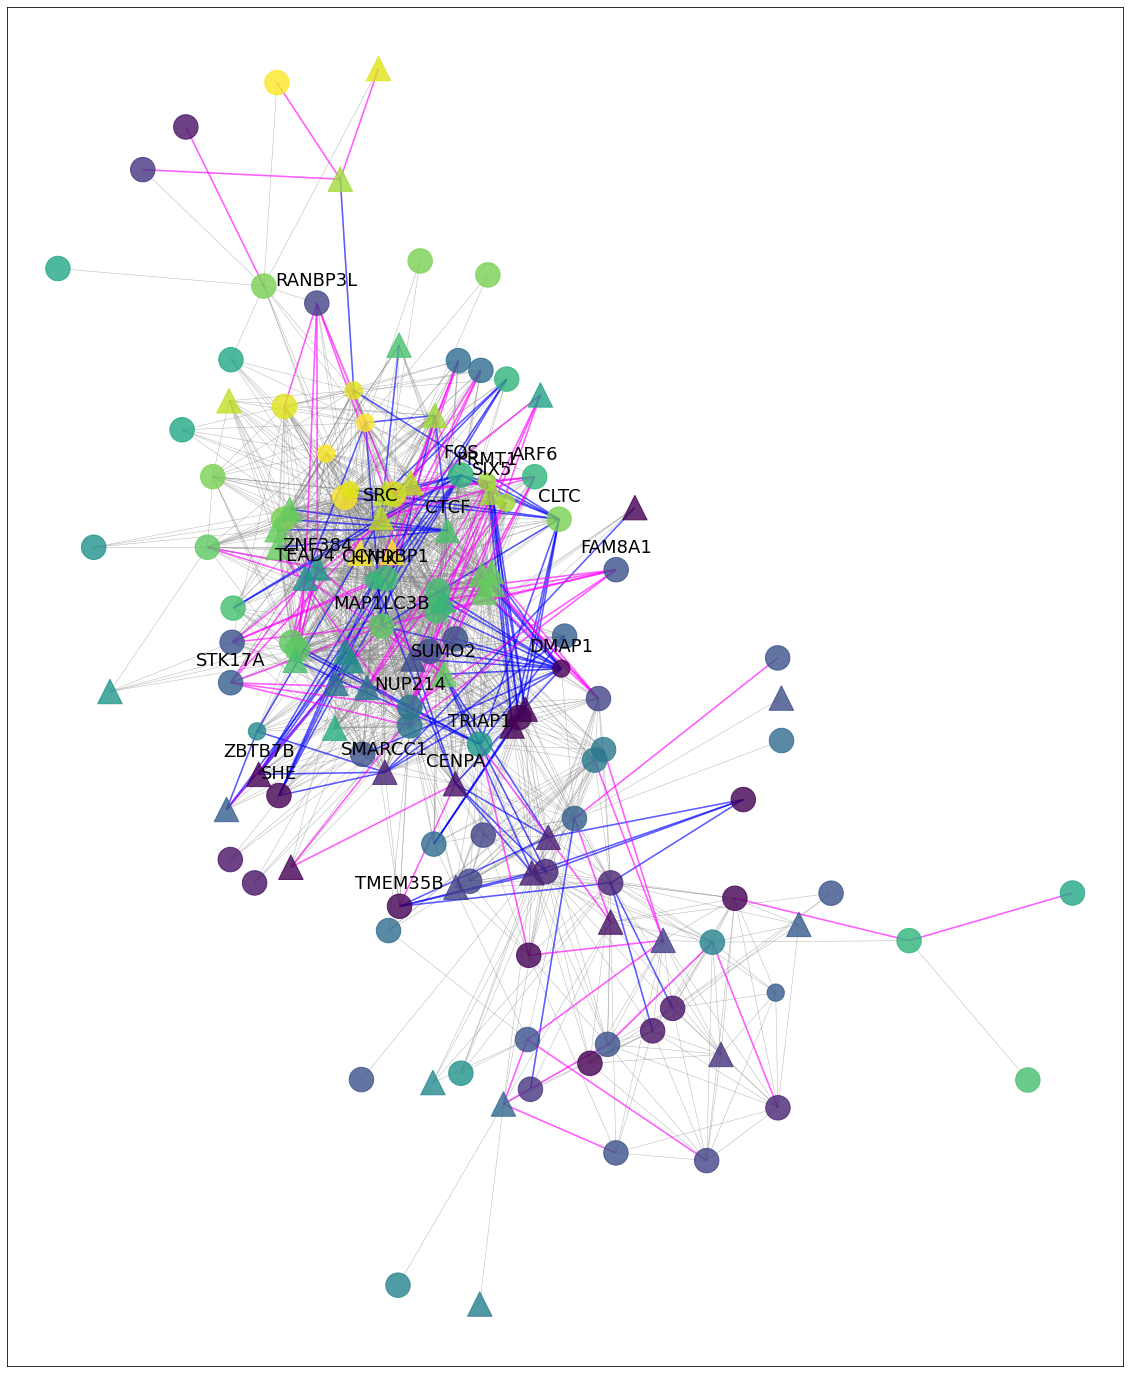

In [214]:
# draw network
plt.figure(figsize = (20,25))
pos = nx.layout.kamada_kawai_layout(network, #_wo_shared,
                                    weight=None,
                                    scale=10)

# Draw terminals 
DE_up_nodes = all_nodes[all_nodes['updown'] == 'up'].index.tolist()
DE_down_nodes = all_nodes[all_nodes['updown'] == 'down'].index.tolist()
TF_nodes = all_nodes[all_nodes['updown'] == 'Bridge TF'].index.tolist()
# Upregulated DE genes 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = DE_up_nodes,
                       node_color= all_nodes.loc[DE_up_nodes, 'chromosome'].cat.codes,
                       node_size=600,
                       node_shape='o',
                       alpha=0.8)
# Downregulated DE genes 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = DE_down_nodes,
                       node_color= all_nodes.loc[DE_down_nodes, 'chromosome'].cat.codes,
                       node_size=300,
                       node_shape='o',
                       alpha=0.8)
# Bridge TFs
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = TF_nodes,
                       node_color = all_nodes.loc[TF_nodes, 'chromosome'].cat.codes,
                       node_size=600,
                       node_shape='^',
                       alpha=0.8)

# Draw edges
# shared interchromosomal intermingling
shared_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 3].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = shared_edges,
                       width=0.5, 
                       alpha=0.3, 
                       edge_color='grey')
# young-specific intermingling
young_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 1].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = young_edges,
                       width=1.5, 
                       alpha=0.4, 
                       edge_color='blue')
# old-specific intermingling
old_edges = [(diff_map_long.loc[diff_map_long.index == ix, 'gene1'].item(), 
                diff_map_long.loc[diff_map_long.index == ix, 'gene2'].item()) 
               for ix in diff_map_long[diff_map_long['value'] == 2].index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = old_edges,
                       width=1.5, 
                       alpha=0.4, 
                       edge_color='magenta')


# Draw labels
labels = {}
for node in all_nodes.index:
    degree = diff_map_long_wo_shared[(diff_map_long_wo_shared['gene1'] == node)].shape[0]
    if degree > 5: 
        labels[node] = node

#labels = {protein: community_dict[protein] for protein in all_nodes.index}
new_pos = {protein: np.array([x, y + 0.3]) 
           for protein, (x,y) in pos.items()}
nx.draw_networkx_labels(network,
                        pos = new_pos,
                        labels = labels,
                        font_size=18)

plt.savefig(fig_dir + 'network_group5_up_TFs.png', dpi = 500, bbox_inches="tight")
plt.show()